In [1]:
!pip install vllm matplotlib autoawq accelerate

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [1]:
from vllm import LLM, SamplingParams
import time

In [2]:
prompts = [
    "Hello, my name is",
    "The president of the United States is",
    "The capital of France is",
    "The future of AI is",
]
max_tokens = 50
sampling_params = SamplingParams(temperature=0.8, top_p=0.95)

In [3]:
model_path = "/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/Qwen/Qwen2-7B-Instruct"
llm = LLM(model=model_path, gpu_memory_utilization=0.9)

INFO 03-14 16:23:54 __init__.py:207] Automatically detected platform cuda.
INFO 03-14 16:24:01 config.py:549] This model supports multiple tasks: {'reward', 'classify', 'generate', 'embed', 'score'}. Defaulting to 'generate'.
INFO 03-14 16:24:01 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/Qwen/Qwen2-7B-Instruct', speculative_config=None, tokenizer='/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/Qwen/Qwen2-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observabi

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 03-14 16:27:34 model_runner.py:1115] Loading model weights took 14.2487 GB
INFO 03-14 16:27:37 worker.py:267] Memory profiling takes 2.60 seconds
INFO 03-14 16:27:37 worker.py:267] the current vLLM instance can use total_gpu_memory (79.33GiB) x gpu_memory_utilization (0.90) = 71.39GiB
INFO 03-14 16:27:37 worker.py:267] model weights take 14.25GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 4.35GiB; the rest of the memory reserved for KV Cache is 52.70GiB.
INFO 03-14 16:27:37 executor_base.py:111] # cuda blocks: 61673, # CPU blocks: 4681
INFO 03-14 16:27:37 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 30.11x
INFO 03-14 16:27:40 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:15<00:00,  2.26it/s]

INFO 03-14 16:27:55 model_runner.py:1562] Graph capturing finished in 16 secs, took 0.78 GiB
INFO 03-14 16:27:55 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 21.48 seconds


## FP16

In [4]:
# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(10)]
for batch_size in batch_sizes:
    print(f"bs={batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompt = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]

    outputs = llm.generate(batch_prompt, sampling_params)

    duration_s = time.time() - t0

    # calculate throughput
    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print(f"duration: {duration_s}")
    print(f"throughput: {throughput} tokens/s")
    print(f"avg latency: {avg_latency}")
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)


bs=1


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.16it/s, est. speed input: 20.91 toks/s, output: 66.92 toks/s]


duration: 0.24758529663085938
throughput: 201.95060320786405 tokens/s
avg latency: 0.004951705932617187

bs=2


Processed prompts: 100%|██████████| 2/2 [00:00<00:00,  8.91it/s, est. speed input: 53.48 toks/s, output: 142.60 toks/s]


duration: 0.23075509071350098
throughput: 433.3598868427877 tokens/s
avg latency: 0.004615101814270019

bs=4


Processed prompts: 100%|██████████| 4/4 [00:00<00:00, 18.88it/s, est. speed input: 103.87 toks/s, output: 302.16 toks/s]


duration: 0.21710586547851562
throughput: 921.2095654771317 tokens/s
avg latency: 0.0043421173095703125

bs=8


Processed prompts: 100%|██████████| 8/8 [00:00<00:00, 35.80it/s, est. speed input: 196.98 toks/s, output: 573.01 toks/s]


duration: 0.22869133949279785
throughput: 1749.082413383639 tokens/s
avg latency: 0.004573826789855957

bs=16


Processed prompts: 100%|██████████| 16/16 [00:00<00:00, 67.15it/s, est. speed input: 369.59 toks/s, output: 1075.13 toks/s]


duration: 0.24472355842590332
throughput: 3268.9946368290557 tokens/s
avg latency: 0.004894471168518067

bs=32


Processed prompts: 100%|██████████| 32/32 [00:00<00:00, 118.16it/s, est. speed input: 650.06 toks/s, output: 1891.02 toks/s]


duration: 0.28003883361816406
throughput: 5713.493301366971 tokens/s
avg latency: 0.005600776672363281

bs=64


Processed prompts: 100%|██████████| 64/64 [00:00<00:00, 181.36it/s, est. speed input: 997.68 toks/s, output: 2902.26 toks/s]


duration: 0.36634087562561035
throughput: 8735.033988591287 tokens/s
avg latency: 0.007326817512512207

bs=128


Processed prompts: 100%|██████████| 128/128 [00:00<00:00, 261.72it/s, est. speed input: 1439.70 toks/s, output: 4188.14 toks/s]


duration: 0.5132193565368652
throughput: 12470.301282450322 tokens/s
avg latency: 0.010264387130737304

bs=256


Processed prompts: 100%|██████████| 256/256 [00:00<00:00, 329.02it/s, est. speed input: 1809.75 toks/s, output: 5264.67 toks/s]


duration: 0.8309545516967773
throughput: 15403.971220643645 tokens/s
avg latency: 0.016619091033935548

bs=512


Processed prompts: 100%|██████████| 512/512 [00:01<00:00, 334.49it/s, est. speed input: 1839.81 toks/s, output: 5352.14 toks/s]

duration: 1.608248233795166
throughput: 15917.940689783176 tokens/s
avg latency: 0.032164964675903324



In [5]:
# save observations and restart kernel
# save as json
import json

data = {
    "durations": durations,
    "throughputs": throughputs,
    "latencies": latencies,
    "batch_sizes": batch_sizes,
    "prompts": prompts,
    "max_tokens": max_tokens

}

with open("basic_fp16_inference_observation.json", "w") as f:
    json.dump(data, f)

In [1]:
import json

# Read the data from the JSON file
with open("basic_fp16_inference_observation.json", "r") as f:
    data = json.load(f)

# Restore the lists
durations = data["durations"]
throughputs = data["throughputs"]
latencies = data["latencies"]
batch_sizes = data["batch_sizes"]
prompts = data["prompts"]
max_tokens = data["max_tokens"]

## AWQ

In [2]:
from vllm import LLM, SamplingParams
import matplotlib.pyplot as plt
import time

In [3]:
sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=max_tokens)

In [ ]:
model = "/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/Qwen/Qwen2-7B-Instruct-AWQ"
# Create an LLM.
llm_awq = LLM(model=model, quantization="awq_marlin", gpu_memory_utilization=0.9)

INFO 03-14 16:28:46 __init__.py:207] Automatically detected platform cuda.
INFO 03-14 16:28:53 config.py:549] This model supports multiple tasks: {'generate', 'classify', 'embed', 'reward', 'score'}. Defaulting to 'generate'.
INFO 03-14 16:28:54 awq_marlin.py:114] The model is convertible to awq_marlin during runtime. Using awq_marlin kernel.
INFO 03-14 16:28:54 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/Qwen/Qwen2-7B-Instruct-AWQ', speculative_config=None, tokenizer='/root/autodl-fs/data2/anti_fraud/models/modelscope/hub/hub/Qwen/Qwen2-7B-Instruct-AWQ', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=awq_marlin, enforce_

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 03-14 16:29:25 model_runner.py:1115] Loading model weights took 5.2048 GB
INFO 03-14 16:29:29 worker.py:267] Memory profiling takes 3.56 seconds
INFO 03-14 16:29:29 worker.py:267] the current vLLM instance can use total_gpu_memory (79.33GiB) x gpu_memory_utilization (0.90) = 71.39GiB
INFO 03-14 16:29:29 worker.py:267] model weights take 5.20GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 5.51GiB; the rest of the memory reserved for KV Cache is 60.58GiB.
INFO 03-14 16:29:29 executor_base.py:111] # cuda blocks: 70897, # CPU blocks: 4681
INFO 03-14 16:29:29 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 34.62x
INFO 03-14 16:29:32 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_u

Capturing CUDA graph shapes:  31%|███▏      | 11/35 [00:05<00:11,  2.05it/s]

In [ ]:
# observations
durations_with_awq = []
throughputs_with_awq = []
latencies_with_awq = []

for batch_size in batch_sizes:
    print(f"bs={batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompt = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]

    outputs = llm_awq.generate(batch_prompt, sampling_params)

    duration_s = time.time() - t0

    # calculate throughput
    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print(f"duration: {duration_s}")
    print(f"throughput: {throughput} tokens/s")
    print(f"avg latency: {avg_latency}")
    print()

    durations_with_awq.append(duration_s)
    throughputs_with_awq.append(throughput)
    latencies_with_awq.append(avg_latency)

bs=1


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  6.14it/s, est. speed input: 30.85 toks/s, output: 61.68 toks/s]


duration: 0.1689739227294922
throughput: 59.18072941946699 tokens/s
avg latency: 0.01689739227294922

bs=2


Processed prompts: 100%|██████████| 2/2 [00:00<00:00, 15.39it/s, est. speed input: 92.41 toks/s, output: 153.99 toks/s]


duration: 0.13430190086364746
throughput: 148.91821985680886 tokens/s
avg latency: 0.013430190086364747

bs=4


Processed prompts: 100%|██████████| 4/4 [00:00<00:00, 33.41it/s, est. speed input: 183.96 toks/s, output: 334.21 toks/s]


duration: 0.12446737289428711
throughput: 321.3693602577511 tokens/s
avg latency: 0.012446737289428711

bs=8


Processed prompts: 100%|██████████| 8/8 [00:00<00:00, 57.77it/s, est. speed input: 317.90 toks/s, output: 577.95 toks/s]


duration: 0.14531254768371582
throughput: 550.5374537519381 tokens/s
avg latency: 0.014531254768371582

bs=16


Processed prompts: 100%|██████████| 16/16 [00:00<00:00, 100.20it/s, est. speed input: 551.41 toks/s, output: 1002.49 toks/s]


duration: 0.16640901565551758
throughput: 961.486367608923 tokens/s
avg latency: 0.016640901565551758

bs=32


Processed prompts: 100%|██████████| 32/32 [00:00<00:00, 144.43it/s, est. speed input: 794.72 toks/s, output: 1444.89 toks/s]


duration: 0.23043012619018555
throughput: 1388.7073070293245 tokens/s
avg latency: 0.023043012619018553

bs=64


Processed prompts: 100%|██████████| 64/64 [00:00<00:00, 188.13it/s, est. speed input: 1034.96 toks/s, output: 1881.68 toks/s]


duration: 0.3538320064544678
throughput: 1808.7679698991765 tokens/s
avg latency: 0.035383200645446776

bs=128


Processed prompts: 100%|██████████| 128/128 [00:00<00:00, 224.14it/s, est. speed input: 1232.94 toks/s, output: 2241.66 toks/s]


duration: 0.5949976444244385
throughput: 2151.269020969298 tokens/s
avg latency: 0.05949976444244385

bs=256


Processed prompts:   0%|          | 0/256 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

In [6]:
def render_plot(x, y1, y2, y3, y4, x_label, y1_label, y2_label):
    fig, ax1 = plt.subplots()

    # plot the first line (FP32 throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color, label='FP16 Throughput', linestyle='-')
    ax1.tick_params(axis='y', labelcolor=color)

    # plot the third line (AWQ throughput)
    ax1.plot(x, y3, color=color, label='AWQ Throughput', linestyle='--')

    # set the x-axis to be log scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)
    ax2.plot(x, y2, color=color, label='FP16 Latency', linestyle='-')
    ax2.tick_params(axis='y', labelcolor=color)

    # plot the fourth line (AWQ latency)
    ax2.plot(x, y4, color=color, label='AWQ Latency', linestyle='--')

    # Add legends
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.show()

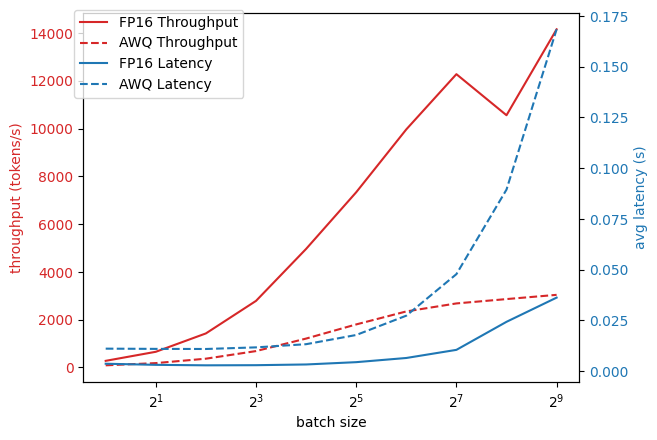

In [7]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    throughputs_with_awq,
    latencies_with_awq,
    "batch size",
    "throughput (tokens/s)",
    "avg latency (s)"
)